In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Ybigta/신입기수 프로젝트/감성분석 model/training_data_for_lstm.csv')
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,row_num,LSTM_pp,label_mod
0,0,"그냥/Noun,그렇다/Adjective,생각/Noun,하다/Verb,다른/Noun,...",1
1,2,"도넛/Noun,맛있다/Adjective,종업원/Noun,대응/Noun,너무/Adve...",0
2,3,"도넛/Noun,맛/Noun,있다/Adjective,줄이다/Verb,진짜/Noun,너...",1
3,5,"바닐라/Noun,맛/Noun,맛있다/Adjective,도/Noun,넛/Noun,살다...",1
4,7,"계산/Noun,해주다/Verb,직원/Noun,불친절하다/Adjective,크다/Ve...",0


In [4]:
y = []
for i in data.label_mod:
  y.append(i)
y[:5]

[1, 0, 1, 1, 0]

In [5]:
X = []
for i in data.LSTM_pp:
  xinnerlist = i.split(',')
  X.append(xinnerlist)

X[:2]

[['그냥/Noun',
  '그렇다/Adjective',
  '생각/Noun',
  '하다/Verb',
  '다른/Noun',
  '곳/Noun',
  '넛/Noun',
  '먹다/Verb',
  '나다/Verb',
  '킹/Noun',
  '드/Noun',
  '자다/Verb',
  '되다/Verb',
  '이유/Noun',
  '있다/Adjective',
  '근데/Adverb',
  '그냥/Noun',
  '갤러리아/Noun',
  '지하/Noun',
  '먹다/Verb',
  '게/Noun',
  '갑자기/Noun',
  '확장/Noun',
  '이전/Noun',
  '하다/Verb',
  '웨이/Noun',
  '팅/Noun',
  '생기다/Verb',
  '뭐/Noun'],
 ['도넛/Noun',
  '맛있다/Adjective',
  '종업원/Noun',
  '대응/Noun',
  '너무/Adverb',
  '느리다/Adjective',
  '한남/Noun',
  '삼성/Noun',
  '점도/Noun',
  '가보다/Verb',
  '여기/Noun',
  '유난히/Adverb',
  '손/Noun',
  '느리다/Adjective',
  '듯/Noun',
  '직원/Noun',
  '많다/Adjective',
  '왜/Noun',
  '이렇게/Adverb',
  '느리다/Adjective',
  '건지다/Verb',
  '이해/Noun',
  '좀/Noun',
  '안/Noun',
  '되다/Verb']]

##Train, Test split

In [6]:
!pip install sklearn

import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [8]:
y_train_df = pd.DataFrame(y_train)
y_train_df

,0
0,0
1,0
2,1
3,0
4,1
...,...
19733,1
19734,0
19735,1
19736,1


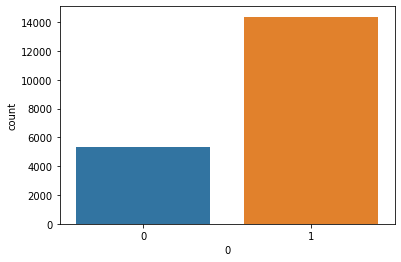

In [9]:
import seaborn as sns

ax = sns.countplot(x = 0, data = y_train_df)

##정수인코딩, Tokenizer

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [11]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11692
등장 빈도가 2번 이하인 희귀 단어의 수: 6152
단어 집합에서 희귀 단어의 비율: 52.61717413616148
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.060536914807271


In [12]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5542


In [13]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] 

In [14]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

19738
19738


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index

X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
import json
json = json.dumps(word_index)
f3 = open("/content/drive/MyDrive/Ybigta/신입기수 프로젝트/감성분석 model/wordIndex(BiLSTM+Attention).json", "w")
f3.write(json)
f3.close()

#data = pad_sequences(X_train, maxlen=max_len)

In [17]:
y_test

[0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


In [18]:

y_test = np.array(y_test)

##패딩

리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 13.233154321613132


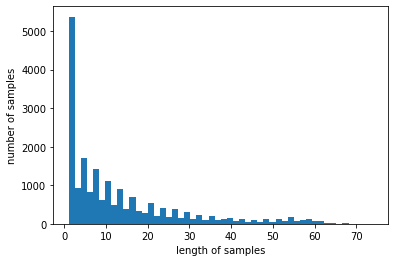

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 87.52153207011855


In [22]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

##바다나우 Attention

In [25]:
import tensorflow as tf

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

##BiLSTM + Attention 감성분석 모델링

In [124]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [125]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [126]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [127]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [128]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 30, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [129]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [130]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [131]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="tanh")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [132]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('BiLSTM_Attention_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [133]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [134]:
history = model.fit(X_train, y_train, epochs = 4, callbacks=[es, mc], batch_size = 128, validation_split=0.3)

Epoch 1/4
108/108 [==============================] - 50s 310ms/step - loss: 2.1168 - accuracy: 0.3818 - val_loss: 0.2947 - val_accuracy: 0.8967
Epoch 2/4
108/108 [==============================] - 28s 257ms/step - loss: 0.2567 - accuracy: 0.9146 - val_loss: 0.2187 - val_accuracy: 0.9218
Epoch 3/4
108/108 [==============================] - 28s 259ms/step - loss: 0.1761 - accuracy: 0.9475 - val_loss: 0.2489 - val_accuracy: 0.9223
Epoch 4/4
108/108 [==============================] - 28s 259ms/step - loss: 0.1402 - accuracy: 0.9595 - val_loss: 0.2851 - val_accuracy: 0.9222


In [135]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

155/155 [==============================] - 5s 33ms/step - loss: 0.2622 - accuracy: 0.9204

 테스트 정확도: 0.9204
